# <center> Image Segmentation
Reference:
- https://github.com/fastai/course-v3/blob/master/nbs/dl1/lesson3-camvid.ipynb (2019, outdated)
- https://walkwithfastai.com/Segmentation#Transfer-Learning-between-DataSets (2021)

In [1]:
from fastai.vision.all import *

# Dowload dataset

In [2]:
path = untar_data(URLs.CAMVID)     # Image size = (720, 960)
#path = untar_data(URLs.CAMVID_TINY) # Image size = (96, 128)
path.ls()

(#4) [Path('/home/javi/.fastai/data/camvid/labels'),Path('/home/javi/.fastai/data/camvid/valid.txt'),Path('/home/javi/.fastai/data/camvid/codes.txt'),Path('/home/javi/.fastai/data/camvid/images')]

In [3]:
path_lbl = path/'labels'
path_img = path/'images'

# X: Image

In [4]:
fnames = get_image_files(path_img)
fnames[:3]

(#3) [Path('/home/javi/.fastai/data/camvid/images/Seq05VD_f03420.png'),Path('/home/javi/.fastai/data/camvid/images/0001TP_010140.png'),Path('/home/javi/.fastai/data/camvid/images/0016E5_00930.png')]

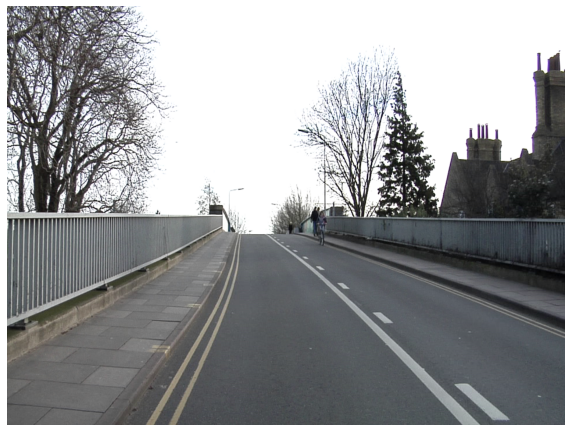

In [5]:
img_f = fnames[0]
img = PILImage.create(img_f)
img.show(figsize=(10,10));

# Y: Image piexel labels

In [6]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

(#3) [Path('/home/javi/.fastai/data/camvid/labels/Seq05VD_f00570_P.png'),Path('/home/javi/.fastai/data/camvid/labels/0016E5_06480_P.png'),Path('/home/javi/.fastai/data/camvid/labels/0016E5_07650_P.png')]

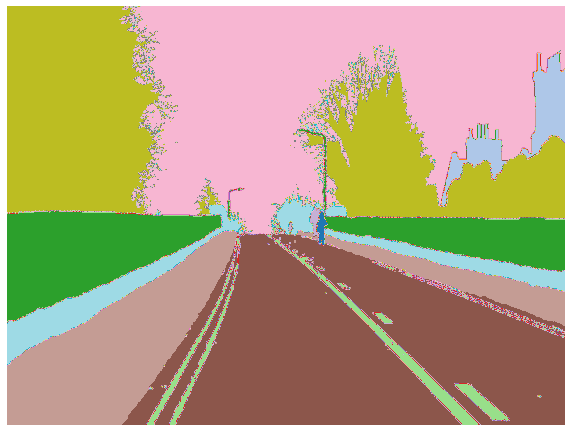

In [7]:
get_mask = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'
mask = PILMask.create(get_mask(img_f))
mask.show(figsize=(10,10), alpha=1);

Now if we look at what our mask actually is, we can see it's a giant array of pixels:

In [8]:
tensor(mask)

tensor([[26, 26, 26,  ..., 21, 21, 21],
        [26, 26, 26,  ..., 21, 21, 21],
        [26, 26, 26,  ..., 21, 21, 21],
        ...,
        [19, 19, 19,  ..., 17, 17, 17],
        [19, 19, 19,  ..., 17, 17, 17],
        [19, 19, 19,  ..., 17, 17, 17]], dtype=torch.uint8)

In [9]:
codes = np.loadtxt(path/'codes.txt', dtype=str)
codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car',
       'CartLuggagePram', 'Child', 'Column_Pole', 'Fence', 'LaneMkgsDriv',
       'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving',
       'ParkingBlock', 'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk',
       'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel',
       'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

# Create dataset

In [10]:
sz = mask.shape; sz

(720, 960)

In [11]:
sz_half = tuple(x//2 for x in sz)
sz_half

(360, 480)

In [12]:
camvid = DataBlock(blocks    = (ImageBlock, MaskBlock(codes)),
                   get_items = get_image_files,
                   splitter  = RandomSplitter(valid_pct=0.2, seed=0), # FileSplitter(path/'valid.txt'),
                   get_y     = get_mask,
                   batch_tfms=[*aug_transforms(size=sz_half),
                               Normalize.from_stats(*imagenet_stats)] )

# Create dataloader

In [13]:
dls = camvid.dataloaders(path/'images', bs=8) # bs=16

/usr/lib/python3.9/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /build/python-pytorch/src/pytorch-1.9.1-opt-cuda/aten/src/ATen/native/BinaryOps.cpp:461.)
  return torch.floor_divide(self, other)
/usr/lib/python3.9/site-packages/torch/_tensor.py:1023: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = 

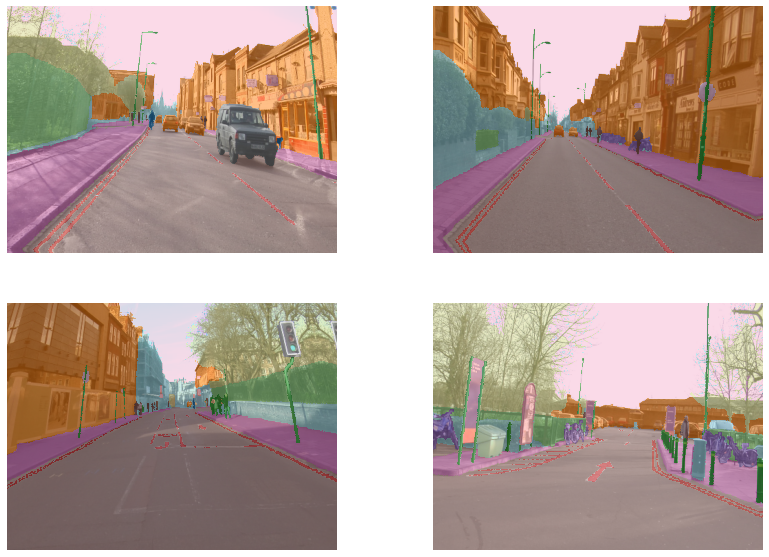

In [14]:
dls.show_batch(max_n=4, vmin=1, vmax=30, figsize=(14,10))

Lastly let's make our vocabulary a part of our DataLoaders, as our loss function needs to deal with the Void label

In [15]:
dls.vocab = codes

Now we need a methodology for grabbing that particular code from our output of numbers. Let's make everything into a dictionary

In [16]:
name2id = {v:k for k,v in enumerate(codes)}
name2id

{'Animal': 0,
 'Archway': 1,
 'Bicyclist': 2,
 'Bridge': 3,
 'Building': 4,
 'Car': 5,
 'CartLuggagePram': 6,
 'Child': 7,
 'Column_Pole': 8,
 'Fence': 9,
 'LaneMkgsDriv': 10,
 'LaneMkgsNonDriv': 11,
 'Misc_Text': 12,
 'MotorcycleScooter': 13,
 'OtherMoving': 14,
 'ParkingBlock': 15,
 'Pedestrian': 16,
 'Road': 17,
 'RoadShoulder': 18,
 'Sidewalk': 19,
 'SignSymbol': 20,
 'Sky': 21,
 'SUVPickupTruck': 22,
 'TrafficCone': 23,
 'TrafficLight': 24,
 'Train': 25,
 'Tree': 26,
 'Truck_Bus': 27,
 'Tunnel': 28,
 'VegetationMisc': 29,
 'Void': 30,
 'Wall': 31}

In [17]:
void_code = name2id['Void']
void_code

30

For segmentation, we want to squeeze all the outputted values to have it as a matrix of digits for our segmentation mask. From there, we want to match their argmax to the target's mask for each pixel and take the average

In [18]:
def acc_camvid(inp, targ):
    targ = targ.squeeze(1)
    mask = targ != void_code
    return (inp.argmax(dim=1)[mask]==targ[mask]).float().mean()

# Then we train a Unet for a few epochs.
### Unet with a resnet18 backbone

In [19]:
learn = unet_learner(dls            = dls,
                     arch           = resnet18, #resnet34,
                     metrics        = acc_camvid,
                     self_attention = True,
                     act_cls        = Mish,
                     opt_func       = ranger)

In [20]:
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

In [21]:
learn.summary()

DynamicUnet (Input shape: 8)
Layer (type)         Output Shape         Param #    Trainable 
                     8 x 64 x 180 x 240  
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
MaxPool2d                                                      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                      

/home/javi/.local/lib/python3.9/site-packages/fastai/callback/schedule.py:269: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


SuggestedLRs(minimum=0.001096478197723627, steep=0.0014454397605732083, valley=0.00013182566908653826, slide=0.0012022644514217973)

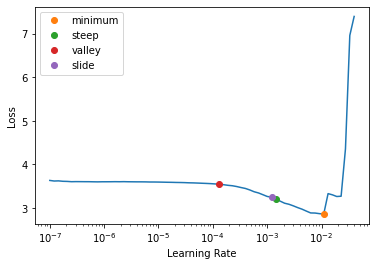

In [22]:
learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

In [23]:
lr = 1e-3

In [24]:
learn.fit_one_cycle(n_epoch=10, lr_max=lr)
# learn.fit_flat_cos(10, slice(lr))

epoch,train_loss,valid_loss,acc_camvid,time
0,2.122775,1.025318,0.775396,00:50
1,1.054076,0.751046,0.820920,00:50
2,0.759973,0.502818,0.877349,00:51
3,0.573034,0.472289,0.881138,00:50
4,0.478399,0.424212,0.892730,00:50
5,0.431810,0.352155,0.906553,00:51
6,0.378093,0.339705,0.908674,00:51
7,0.332640,0.309179,0.916645,00:51
8,0.300725,0.300850,0.917486,00:50
9,0.282628,0.298700,0.918385,00:50


In [25]:
learn.save('stage-1')
learn.load('stage-1')

# Show results

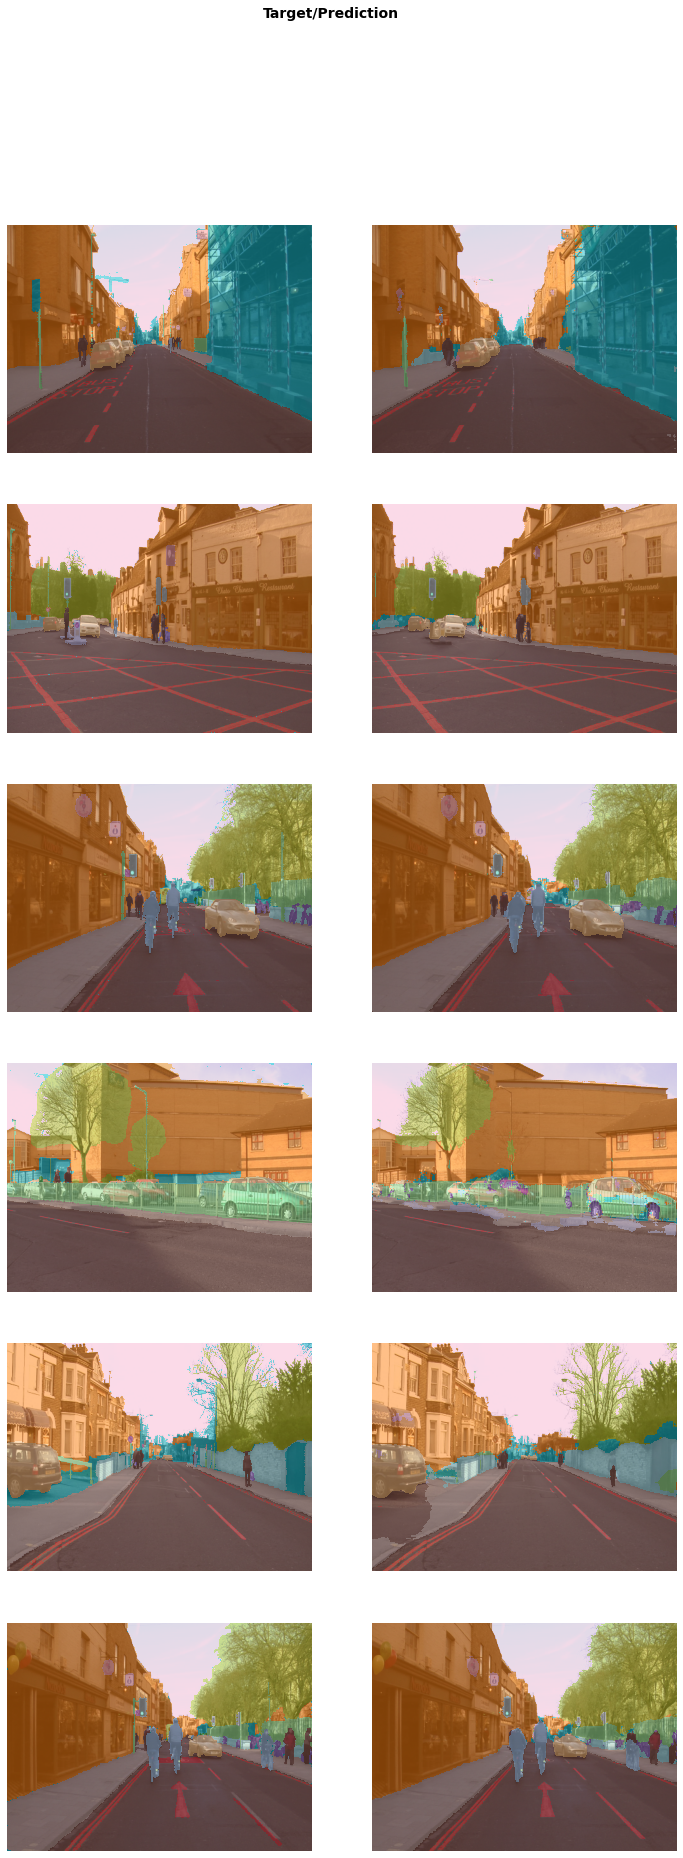

In [26]:
learn.show_results(max_n=6, figsize=(12,30))

Let's unfreeze the model and decrease our learning rate by 4 (Rule of thumb)

In [2]:
#learn.unfreeze()

In [3]:
#learn.fit_one_cycle(n_epoch=10, lr_max=lr/4)

Now let's save that model away

In [4]:
#learn.save('stage-2')

In [5]:
#interp = SegmentationInterpretation.from_learner(learn)

In [6]:
#interp.plot_top_losses(k=6, figsize=(10,20))

In [7]:
#learn.show_results(max_n=6, figsize=(12,30))